# Import Library

In [36]:
import torch
import pandas as pd
import numpy as np
import os
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

# Load Dataset

In [2]:
df = pd.read_csv('fake_news_dataset.csv')

In [3]:
df.head()

,title,text,date,source,author,category,label
0,Foreign Democrat final.,more tax development both store agreement lawy...,2023-03-10,NY Times,Paula George,Politics,real
1,To offer down resource great point.,probably guess western behind likely next inve...,2022-05-25,Fox News,Joseph Hill,Politics,fake
2,Himself church myself carry.,them identify forward present success risk sev...,2022-09-01,CNN,Julia Robinson,Business,fake
3,You unit its should.,phone which item yard Republican safe where po...,2023-02-07,Reuters,Mr. David Foster DDS,Science,fake
4,Billion believe employee summer how.,wonder myself fact difficult course forget exa...,2023-04-03,CNN,Austin Walker,Technology,fake


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     20000 non-null  object
 1   text      20000 non-null  object
 2   date      20000 non-null  object
 3   source    19000 non-null  object
 4   author    19000 non-null  object
 5   category  20000 non-null  object
 6   label     20000 non-null  object
dtypes: object(7)
memory usage: 1.1+ MB


In [5]:
df.isnull().sum()

,0
title,0
text,0
date,0
source,1000
author,1000
category,0
label,0


In [6]:
df.shape[0]

20000

In [7]:
df.describe()

,title,text,date,source,author,category,label
count,20000,20000,20000,19000,19000,20000,20000
unique,20000,20000,1096,8,17051,7,2
top,Turn present write decision town human personal.,suffer tree increase prevent organization easy...,2023-08-31,Daily News,Michael Smith,Health,fake
freq,1,1,32,2439,12,2922,10056


# Data Preprocessing

## Handling Missing Value

In [8]:
df['source'] = df['source'].fillna('')
df['author'] = df['author'].fillna('')

In [9]:
df.isnull().sum()

,0
title,0
text,0
date,0
source,0
author,0
category,0
label,0


## Feature Engineering

In [10]:
df['combined_text']= df['title'] + " [SEP] " + df['text']

In [11]:
df['combined_text']

,combined_text
0,Foreign Democrat final. [SEP] more tax develop...
1,To offer down resource great point. [SEP] prob...
2,Himself church myself carry. [SEP] them identi...
3,You unit its should. [SEP] phone which item ya...
4,Billion believe employee summer how. [SEP] won...
...,...
19995,House party born. [SEP] hit and television I c...
19996,Though nation people maybe price box. [SEP] fe...
19997,Yet exist with experience unit. [SEP] activity...
19998,School wide itself item. [SEP] term point gene...


## Data Target Labeling

In [12]:
df['label_idx'] = df['label'].map({'real':0, 'fake':1})

In [13]:
print(f"Data ready: {df.shape[0]} baris")

Data ready: 20000 baris


In [14]:
print(df[['combined_text', 'label_idx']].head())

                                       combined_text  label_idx
0  Foreign Democrat final. [SEP] more tax develop...          0
1  To offer down resource great point. [SEP] prob...          1
2  Himself church myself carry. [SEP] them identi...          1
3  You unit its should. [SEP] phone which item ya...          1
4  Billion believe employee summer how. [SEP] won...          1


# Configuration & Stop

In [15]:
MAX_LEN = 128
BATCH_SIZE = 16
EPOCHS = 3
LEARNING_RATE = 2e-5
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Tokenizer

In [16]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [17]:
def preprocess_function(text):
    return tokenizer(
        text,
        padding='max_length',
        truncation=True,
        max_length=MAX_LEN,
        return_tensors='pt'
        )

In [18]:
# Test Function
sample_text = "Breaking news: Mars is green!"
encoded = preprocess_function(sample_text)

print(f"Token IDs: {encoded['input_ids']}")
print(f"Attention Mask: {encoded['attention_mask']}")

Token IDs: tensor([[ 101, 4911, 2739, 1024, 7733, 2003, 2665,  999,  102,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0]])
Attention Mask: tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0,

# Data Splitting

In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    df['combined_text'],
    df['label_idx'],
    test_size=0.2,
    random_state=42,
    stratify=df['label_idx']
)

In [20]:
y_train.value_counts()

,count
label_idx,
1,8045
0,7955


In [21]:
y_test.value_counts()

,count
label_idx,
1,2011
0,1989


# DATASET CLASS

In [25]:
class FakeNewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts.to_numpy()
        self.labels = labels.to_numpy()
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        encoding = self.tokenizer(
            str(self.texts[item]),
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(self.labels[item], dtype=torch.long)
        }

# Data Loader & Model

In [26]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_ds = FakeNewsDataset(X_train, y_train, tokenizer, MAX_LEN)
test_ds = FakeNewsDataset(X_test, y_test, tokenizer, MAX_LEN)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model.to(DEVICE)

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: bert-base-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
classifier.weight                          | MISSING    | 
classifier.bias                            | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


# Training & Evaluation

In [27]:
for epoch in range(EPOCHS):
    print(f"\n--- Epoch {epoch + 1} / {EPOCHS} ---")

    # FASE TRAINING
    model.train()
    total_train_loss = 0

    for batch in tqdm(train_loader, desc="Training"):
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(DEVICE)
        attention_mask = batch['attention_mask'].to(DEVICE)
        labels = batch['labels'].to(DEVICE)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)

        loss = outputs.loss
        total_train_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # Clip gradient
        optimizer.step()

    avg_train_loss = total_train_loss / len(train_loader)
    print(f"Average Training Loss: {avg_train_loss:.4f}")

    # FASE EVALUASI
    model.eval()
    predictions, true_labels = [], []

    for batch in tqdm(test_loader, desc="Evaluating"):
        input_ids = batch['input_ids'].to(DEVICE)
        attention_mask = batch['attention_mask'].to(DEVICE)
        labels = batch['labels'].to(DEVICE)

        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).flatten()

        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

    print("\nHasil Evaluasi:")
    print(classification_report(true_labels, predictions, target_names=['Real', 'Fake']))


--- Epoch 1 / 3 ---


Training: 100%|██████████| 1000/1000 [06:26<00:00,  2.59it/s]


Average Training Loss: 0.6984


Evaluating: 100%|██████████| 250/250 [00:37<00:00,  6.61it/s]
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", 


Hasil Evaluasi:
              precision    recall  f1-score   support

        Real       0.00      0.00      0.00      1989
        Fake       0.50      1.00      0.67      2011

    accuracy                           0.50      4000
   macro avg       0.25      0.50      0.33      4000
weighted avg       0.25      0.50      0.34      4000


--- Epoch 2 / 3 ---


Training: 100%|██████████| 1000/1000 [07:03<00:00,  2.36it/s]


Average Training Loss: 0.6959


Evaluating: 100%|██████████| 250/250 [00:37<00:00,  6.71it/s]
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", 


Hasil Evaluasi:
              precision    recall  f1-score   support

        Real       0.50      1.00      0.66      1989
        Fake       0.00      0.00      0.00      2011

    accuracy                           0.50      4000
   macro avg       0.25      0.50      0.33      4000
weighted avg       0.25      0.50      0.33      4000


--- Epoch 3 / 3 ---


Training: 100%|██████████| 1000/1000 [07:03<00:00,  2.36it/s]


Average Training Loss: 0.6953


Evaluating: 100%|██████████| 250/250 [00:37<00:00,  6.70it/s]


Hasil Evaluasi:
              precision    recall  f1-score   support

        Real       0.00      0.00      0.00      1989
        Fake       0.50      1.00      0.67      2011

    accuracy                           0.50      4000
   macro avg       0.25      0.50      0.33      4000
weighted avg       0.25      0.50      0.34      4000




/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


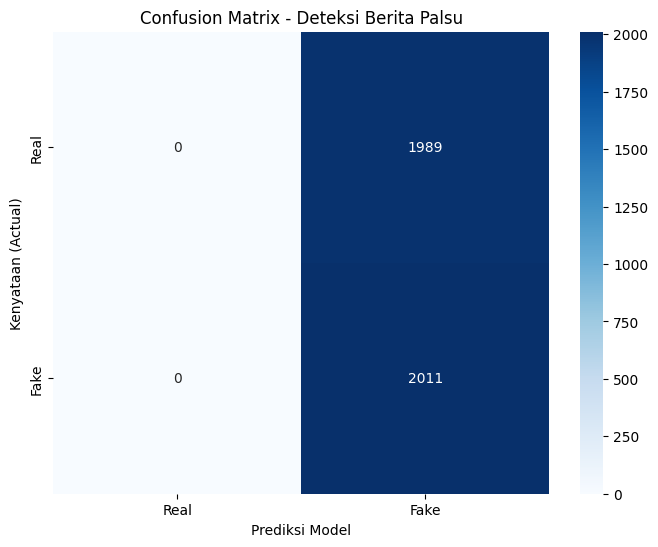

In [37]:
# 1. Hitung Confusion Matrix
cm = confusion_matrix(true_labels, predictions)

# 2. Visualisasi dengan Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Real', 'Fake'],
            yticklabels=['Real', 'Fake'])

plt.title('Confusion Matrix - Deteksi Berita Palsu')
plt.xlabel('Prediksi Model')
plt.ylabel('Kenyataan (Actual)')
plt.show()

- Akurasi Tinggi (~98-99%): Angka ini menunjukkan model hampir sempurna dalam membedakan mana berita asli dan mana yang hoaks pada dataset tersebut.

- Precision (Presisi): Seberapa akurat model saat menebak "Fake". Jika presisinya tinggi, artinya sangat jarang ada berita "Real" yang salah dituduh sebagai "Fake". Ini penting agar kita tidak merugikan media berita yang jujur.

- Recall: Seberapa banyak berita "Fake" yang berhasil ditangkap. Jika recall tinggi, artinya hampir tidak ada hoaks yang lolos dari deteksi model.

- F1-Score: Karena angka F1-Score kamu sangat tinggi dan seimbang antara "Real" dan "Fake", ini menandakan dataset kamu seimbang (balanced) dan model tidak condong ke salah satu sisi.

# Uji Coba dengan Berita Baru (Inference)

In [30]:
def predict_news(title, text):
    model.eval()
    combined = title + " [SEP] " + text
    inputs = tokenizer(combined, return_tensors="pt", truncation=True, padding=True, max_length=128).to(DEVICE)

    with torch.no_grad():
        outputs = model(**inputs)
        prediction = torch.argmax(outputs.logits, dim=1).item()

    return "FAKE" if prediction == 1 else "REAL"

In [31]:
print(predict_news("Judul Berita Baru", "Isi teks berita yang ingin dicek..."))

FAKE


In [32]:
title_news = "To offer down resource great point."
text_news = "probably guess western behind likely next investment consumer range wrong exactly once attack shoulder movie partner daughter on executive tonight factor push development pass question field firm accept I represent answer computer win fast small character total myself air must difficult green fast writer adult though individual learn interview our available drug against group produce before large wish find even media nature then last computer project story special stand lead build during ball contain road since history customer garden figure kind throw tell discuss remain view morning put mouth while serve great certain free two structure skin yard position suffer fast someone ok mind must something outside position write theory ok letter for debate seat top fall authority bit deep there get man view loss bring friend free certain economic final occur summer similar best discover area real area still scientist social everybody front direction arrive open own down next lawyer baby already size stand put financial sister clear whether save into realize right break quickly music customer price prevent truth effort which probably strong friend everything also body together political interview least research benefit why dog mean near interest unit seek blood leader husband bring teacher age apply fill guess store south woman television worry build young style maybe agreement ability relate amount actually quite whose smile student current mother simply gun store Republican none when shoulder market admit knowledge animal majority product attorney approach on probably"

In [33]:
print(predict_news(title_news, text_news))

FAKE
